# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 994us/sample - loss: 271.4251 - y1_output_loss: 124.9104 - y2_output_loss: 144.4189 - y1_output_root_mean_squared_error: 11.2238 - y2_output_root_mean_squared_error: 12.0603 - val_loss: 124.1216 - val_y1_output_loss: 22.5907 - val_y2_output_loss: 105.7120 - val_y1_output_root_mean_squared_error: 4.5780 - val_y2_output_root_mean_squared_error: 10.1570
Epoch 2/500
614/614 [==============================] - 0s 149us/sample - loss: 32.3615 - y1_output_loss: 13.3893 - y2_output_loss: 19.0277 - y1_output_root_mean_squared_error: 3.6455 - y2_output_root_mean_squared_error: 4.3671 - val_loss: 63.5002 - val_y1_output_loss: 14.2427 - val_y2_output_loss: 50.2403 - val_y1_output_root_mean_squared_error: 3.6866 - val_y2_output_root_mean_squared_error: 7.0647
Epoch 3/500
614/614 [==============================] - 0s 144us/sample - loss: 32.4643 - y1_output_loss: 12.3817 - y2_output_loss: 20.0437 -

614/614 [==============================] - 0s 129us/sample - loss: 12.1723 - y1_output_loss: 4.7919 - y2_output_loss: 7.5195 - y1_output_root_mean_squared_error: 2.1810 - y2_output_root_mean_squared_error: 2.7231 - val_loss: 20.5498 - val_y1_output_loss: 5.8158 - val_y2_output_loss: 15.4304 - val_y1_output_root_mean_squared_error: 2.3305 - val_y2_output_root_mean_squared_error: 3.8882
Epoch 22/500
614/614 [==============================] - 0s 137us/sample - loss: 12.5136 - y1_output_loss: 4.7981 - y2_output_loss: 7.6577 - y1_output_root_mean_squared_error: 2.1981 - y2_output_root_mean_squared_error: 2.7717 - val_loss: 9.7503 - val_y1_output_loss: 3.2329 - val_y2_output_loss: 6.5604 - val_y1_output_root_mean_squared_error: 1.7953 - val_y2_output_root_mean_squared_error: 2.5548
Epoch 23/500
614/614 [==============================] - 0s 140us/sample - loss: 13.7203 - y1_output_loss: 5.4060 - y2_output_loss: 8.2664 - y1_output_root_mean_squared_error: 2.3335 - y2_output_root_mean_squared_e

Epoch 42/500
614/614 [==============================] - 0s 139us/sample - loss: 7.9564 - y1_output_loss: 2.6143 - y2_output_loss: 5.3188 - y1_output_root_mean_squared_error: 1.6182 - y2_output_root_mean_squared_error: 2.3104 - val_loss: 9.2416 - val_y1_output_loss: 2.8738 - val_y2_output_loss: 6.7523 - val_y1_output_root_mean_squared_error: 1.6887 - val_y2_output_root_mean_squared_error: 2.5278
Epoch 43/500
614/614 [==============================] - 0s 137us/sample - loss: 7.6774 - y1_output_loss: 2.4661 - y2_output_loss: 5.1694 - y1_output_root_mean_squared_error: 1.5717 - y2_output_root_mean_squared_error: 2.2819 - val_loss: 28.1323 - val_y1_output_loss: 7.7902 - val_y2_output_loss: 21.1518 - val_y1_output_root_mean_squared_error: 2.7271 - val_y2_output_root_mean_squared_error: 4.5492
Epoch 44/500
614/614 [==============================] - 0s 145us/sample - loss: 9.2549 - y1_output_loss: 2.9762 - y2_output_loss: 6.2136 - y1_output_root_mean_squared_error: 1.7270 - y2_output_root_mean

Epoch 63/500
614/614 [==============================] - 0s 140us/sample - loss: 4.3607 - y1_output_loss: 1.1822 - y2_output_loss: 3.1559 - y1_output_root_mean_squared_error: 1.0875 - y2_output_root_mean_squared_error: 1.7827 - val_loss: 6.6912 - val_y1_output_loss: 1.3365 - val_y2_output_loss: 5.4692 - val_y1_output_root_mean_squared_error: 1.1518 - val_y2_output_root_mean_squared_error: 2.3161
Epoch 64/500
614/614 [==============================] - 0s 136us/sample - loss: 7.2052 - y1_output_loss: 2.0820 - y2_output_loss: 5.0666 - y1_output_root_mean_squared_error: 1.4481 - y2_output_root_mean_squared_error: 2.2601 - val_loss: 6.2983 - val_y1_output_loss: 1.2571 - val_y2_output_loss: 5.1248 - val_y1_output_root_mean_squared_error: 1.1203 - val_y2_output_root_mean_squared_error: 2.2457
Epoch 65/500
614/614 [==============================] - 0s 148us/sample - loss: 4.0350 - y1_output_loss: 1.1037 - y2_output_loss: 2.9663 - y1_output_root_mean_squared_error: 1.0439 - y2_output_root_mean_s

Epoch 84/500
614/614 [==============================] - 0s 148us/sample - loss: 3.1023 - y1_output_loss: 0.6479 - y2_output_loss: 2.4416 - y1_output_root_mean_squared_error: 0.8051 - y2_output_root_mean_squared_error: 1.5666 - val_loss: 4.3786 - val_y1_output_loss: 1.3070 - val_y2_output_loss: 3.3170 - val_y1_output_root_mean_squared_error: 1.1321 - val_y2_output_root_mean_squared_error: 1.7598
Epoch 85/500
614/614 [==============================] - 0s 146us/sample - loss: 2.5667 - y1_output_loss: 0.4942 - y2_output_loss: 2.0563 - y1_output_root_mean_squared_error: 0.7062 - y2_output_root_mean_squared_error: 1.4381 - val_loss: 2.7272 - val_y1_output_loss: 0.4884 - val_y2_output_loss: 2.3910 - val_y1_output_root_mean_squared_error: 0.7104 - val_y2_output_root_mean_squared_error: 1.4908
Epoch 86/500
614/614 [==============================] - 0s 132us/sample - loss: 3.3638 - y1_output_loss: 0.7196 - y2_output_loss: 2.6688 - y1_output_root_mean_squared_error: 0.8487 - y2_output_root_mean_s

Epoch 105/500
614/614 [==============================] - 0s 146us/sample - loss: 2.3897 - y1_output_loss: 0.5384 - y2_output_loss: 1.8412 - y1_output_root_mean_squared_error: 0.7356 - y2_output_root_mean_squared_error: 1.3596 - val_loss: 3.9069 - val_y1_output_loss: 1.1441 - val_y2_output_loss: 2.8680 - val_y1_output_root_mean_squared_error: 1.0602 - val_y2_output_root_mean_squared_error: 1.6682
Epoch 106/500
614/614 [==============================] - 0s 144us/sample - loss: 6.6703 - y1_output_loss: 2.0501 - y2_output_loss: 4.5938 - y1_output_root_mean_squared_error: 1.4376 - y2_output_root_mean_squared_error: 2.1456 - val_loss: 3.7337 - val_y1_output_loss: 0.9516 - val_y2_output_loss: 2.8019 - val_y1_output_root_mean_squared_error: 0.9916 - val_y2_output_root_mean_squared_error: 1.6585
Epoch 107/500
614/614 [==============================] - 0s 136us/sample - loss: 3.9614 - y1_output_loss: 0.9480 - y2_output_loss: 3.0138 - y1_output_root_mean_squared_error: 0.9768 - y2_output_root_mea

614/614 [==============================] - 0s 135us/sample - loss: 2.2155 - y1_output_loss: 0.4079 - y2_output_loss: 1.7931 - y1_output_root_mean_squared_error: 0.6399 - y2_output_root_mean_squared_error: 1.3439 - val_loss: 4.2408 - val_y1_output_loss: 0.4383 - val_y2_output_loss: 3.8489 - val_y1_output_root_mean_squared_error: 0.6695 - val_y2_output_root_mean_squared_error: 1.9475
Epoch 126/500
614/614 [==============================] - 0s 144us/sample - loss: 1.8876 - y1_output_loss: 0.3287 - y2_output_loss: 1.5441 - y1_output_root_mean_squared_error: 0.5754 - y2_output_root_mean_squared_error: 1.2476 - val_loss: 2.3308 - val_y1_output_loss: 0.4296 - val_y2_output_loss: 1.9745 - val_y1_output_root_mean_squared_error: 0.6647 - val_y2_output_root_mean_squared_error: 1.3744
Epoch 127/500
614/614 [==============================] - 0s 141us/sample - loss: 1.8796 - y1_output_loss: 0.3631 - y2_output_loss: 1.5747 - y1_output_root_mean_squared_error: 0.6017 - y2_output_root_mean_squared_erro

Epoch 146/500
614/614 [==============================] - 0s 145us/sample - loss: 1.6157 - y1_output_loss: 0.3017 - y2_output_loss: 1.3004 - y1_output_root_mean_squared_error: 0.5515 - y2_output_root_mean_squared_error: 1.1452 - val_loss: 2.1722 - val_y1_output_loss: 0.3456 - val_y2_output_loss: 1.9521 - val_y1_output_root_mean_squared_error: 0.5938 - val_y2_output_root_mean_squared_error: 1.3489
Epoch 147/500
614/614 [==============================] - 0s 142us/sample - loss: 1.7058 - y1_output_loss: 0.3017 - y2_output_loss: 1.3892 - y1_output_root_mean_squared_error: 0.5510 - y2_output_root_mean_squared_error: 1.1842 - val_loss: 2.4879 - val_y1_output_loss: 0.3908 - val_y2_output_loss: 2.1536 - val_y1_output_root_mean_squared_error: 0.6355 - val_y2_output_root_mean_squared_error: 1.4436
Epoch 148/500
614/614 [==============================] - 0s 144us/sample - loss: 1.4028 - y1_output_loss: 0.2485 - y2_output_loss: 1.1470 - y1_output_root_mean_squared_error: 0.4954 - y2_output_root_mea

614/614 [==============================] - 0s 143us/sample - loss: 1.2991 - y1_output_loss: 0.2241 - y2_output_loss: 1.0753 - y1_output_root_mean_squared_error: 0.4733 - y2_output_root_mean_squared_error: 1.0369 - val_loss: 2.9815 - val_y1_output_loss: 0.6786 - val_y2_output_loss: 2.4598 - val_y1_output_root_mean_squared_error: 0.8208 - val_y2_output_root_mean_squared_error: 1.5192
Epoch 167/500
614/614 [==============================] - 0s 141us/sample - loss: 4.0764 - y1_output_loss: 0.8356 - y2_output_loss: 3.2497 - y1_output_root_mean_squared_error: 0.9166 - y2_output_root_mean_squared_error: 1.7989 - val_loss: 17.5757 - val_y1_output_loss: 6.2735 - val_y2_output_loss: 12.0462 - val_y1_output_root_mean_squared_error: 2.4378 - val_y2_output_root_mean_squared_error: 3.4107
Epoch 168/500
614/614 [==============================] - 0s 169us/sample - loss: 2.4477 - y1_output_loss: 0.5776 - y2_output_loss: 1.8526 - y1_output_root_mean_squared_error: 0.7634 - y2_output_root_mean_squared_er

Epoch 187/500
614/614 [==============================] - 0s 141us/sample - loss: 1.2934 - y1_output_loss: 0.2530 - y2_output_loss: 1.0468 - y1_output_root_mean_squared_error: 0.5049 - y2_output_root_mean_squared_error: 1.0191 - val_loss: 3.3656 - val_y1_output_loss: 0.3379 - val_y2_output_loss: 3.0614 - val_y1_output_root_mean_squared_error: 0.5870 - val_y2_output_root_mean_squared_error: 1.7381
Epoch 188/500
614/614 [==============================] - 0s 140us/sample - loss: 1.6809 - y1_output_loss: 0.2941 - y2_output_loss: 1.3758 - y1_output_root_mean_squared_error: 0.5439 - y2_output_root_mean_squared_error: 1.1769 - val_loss: 1.8472 - val_y1_output_loss: 0.3028 - val_y2_output_loss: 1.5866 - val_y1_output_root_mean_squared_error: 0.5572 - val_y2_output_root_mean_squared_error: 1.2397
Epoch 189/500
614/614 [==============================] - 0s 148us/sample - loss: 1.4885 - y1_output_loss: 0.2466 - y2_output_loss: 1.2296 - y1_output_root_mean_squared_error: 0.4988 - y2_output_root_mea

614/614 [==============================] - 0s 146us/sample - loss: 1.3132 - y1_output_loss: 0.2286 - y2_output_loss: 1.1003 - y1_output_root_mean_squared_error: 0.4727 - y2_output_root_mean_squared_error: 1.0439 - val_loss: 1.8519 - val_y1_output_loss: 0.5604 - val_y2_output_loss: 1.3344 - val_y1_output_root_mean_squared_error: 0.7523 - val_y2_output_root_mean_squared_error: 1.1340
Epoch 208/500
614/614 [==============================] - 0s 150us/sample - loss: 1.1498 - y1_output_loss: 0.2024 - y2_output_loss: 0.9464 - y1_output_root_mean_squared_error: 0.4508 - y2_output_root_mean_squared_error: 0.9729 - val_loss: 3.5432 - val_y1_output_loss: 0.6062 - val_y2_output_loss: 3.0149 - val_y1_output_root_mean_squared_error: 0.7750 - val_y2_output_root_mean_squared_error: 1.7154
Epoch 209/500
614/614 [==============================] - 0s 142us/sample - loss: 1.5854 - y1_output_loss: 0.3258 - y2_output_loss: 1.2638 - y1_output_root_mean_squared_error: 0.5723 - y2_output_root_mean_squared_erro

Epoch 228/500
614/614 [==============================] - 0s 169us/sample - loss: 0.8971 - y1_output_loss: 0.1707 - y2_output_loss: 0.7202 - y1_output_root_mean_squared_error: 0.4143 - y2_output_root_mean_squared_error: 0.8517 - val_loss: 1.5853 - val_y1_output_loss: 0.2806 - val_y2_output_loss: 1.3226 - val_y1_output_root_mean_squared_error: 0.5383 - val_y2_output_root_mean_squared_error: 1.1382
Epoch 229/500
614/614 [==============================] - 0s 157us/sample - loss: 1.0201 - y1_output_loss: 0.1775 - y2_output_loss: 0.8342 - y1_output_root_mean_squared_error: 0.4228 - y2_output_root_mean_squared_error: 0.9172 - val_loss: 1.4111 - val_y1_output_loss: 0.3163 - val_y2_output_loss: 1.1242 - val_y1_output_root_mean_squared_error: 0.5722 - val_y2_output_root_mean_squared_error: 1.0410
Epoch 230/500
614/614 [==============================] - 0s 150us/sample - loss: 1.0873 - y1_output_loss: 0.1851 - y2_output_loss: 0.8954 - y1_output_root_mean_squared_error: 0.4315 - y2_output_root_mea

614/614 [==============================] - 0s 151us/sample - loss: 1.1357 - y1_output_loss: 0.2086 - y2_output_loss: 0.9255 - y1_output_root_mean_squared_error: 0.4562 - y2_output_root_mean_squared_error: 0.9631 - val_loss: 2.2914 - val_y1_output_loss: 0.5461 - val_y2_output_loss: 1.7851 - val_y1_output_root_mean_squared_error: 0.7325 - val_y2_output_root_mean_squared_error: 1.3247
Epoch 249/500
614/614 [==============================] - 0s 156us/sample - loss: 0.9365 - y1_output_loss: 0.1615 - y2_output_loss: 0.7710 - y1_output_root_mean_squared_error: 0.4014 - y2_output_root_mean_squared_error: 0.8806 - val_loss: 1.5794 - val_y1_output_loss: 0.3013 - val_y2_output_loss: 1.3179 - val_y1_output_root_mean_squared_error: 0.5527 - val_y2_output_root_mean_squared_error: 1.1287
Epoch 250/500
614/614 [==============================] - 0s 154us/sample - loss: 1.3185 - y1_output_loss: 0.2122 - y2_output_loss: 1.0986 - y1_output_root_mean_squared_error: 0.4614 - y2_output_root_mean_squared_erro

Epoch 269/500
614/614 [==============================] - 0s 145us/sample - loss: 1.3532 - y1_output_loss: 0.2430 - y2_output_loss: 1.1025 - y1_output_root_mean_squared_error: 0.4930 - y2_output_root_mean_squared_error: 1.0537 - val_loss: 1.5701 - val_y1_output_loss: 0.3527 - val_y2_output_loss: 1.2266 - val_y1_output_root_mean_squared_error: 0.6009 - val_y2_output_root_mean_squared_error: 1.0995
Epoch 270/500
614/614 [==============================] - 0s 149us/sample - loss: 0.8269 - y1_output_loss: 0.1646 - y2_output_loss: 0.6604 - y1_output_root_mean_squared_error: 0.4037 - y2_output_root_mean_squared_error: 0.8148 - val_loss: 1.6544 - val_y1_output_loss: 0.4615 - val_y2_output_loss: 1.2270 - val_y1_output_root_mean_squared_error: 0.6806 - val_y2_output_root_mean_squared_error: 1.0914
Epoch 271/500
614/614 [==============================] - 0s 162us/sample - loss: 0.7631 - y1_output_loss: 0.1534 - y2_output_loss: 0.6036 - y1_output_root_mean_squared_error: 0.3930 - y2_output_root_mea

614/614 [==============================] - 0s 147us/sample - loss: 0.8503 - y1_output_loss: 0.1737 - y2_output_loss: 0.6829 - y1_output_root_mean_squared_error: 0.4181 - y2_output_root_mean_squared_error: 0.8219 - val_loss: 2.3157 - val_y1_output_loss: 0.3305 - val_y2_output_loss: 2.1074 - val_y1_output_root_mean_squared_error: 0.5829 - val_y2_output_root_mean_squared_error: 1.4057
Epoch 290/500
614/614 [==============================] - 0s 135us/sample - loss: 0.7036 - y1_output_loss: 0.1553 - y2_output_loss: 0.5520 - y1_output_root_mean_squared_error: 0.3944 - y2_output_root_mean_squared_error: 0.7403 - val_loss: 1.3525 - val_y1_output_loss: 0.3314 - val_y2_output_loss: 1.0682 - val_y1_output_root_mean_squared_error: 0.5816 - val_y2_output_root_mean_squared_error: 1.0071
Epoch 291/500
614/614 [==============================] - 0s 152us/sample - loss: 0.7981 - y1_output_loss: 0.1579 - y2_output_loss: 0.6682 - y1_output_root_mean_squared_error: 0.3954 - y2_output_root_mean_squared_erro

Epoch 310/500
614/614 [==============================] - 0s 146us/sample - loss: 0.7006 - y1_output_loss: 0.1544 - y2_output_loss: 0.5463 - y1_output_root_mean_squared_error: 0.3933 - y2_output_root_mean_squared_error: 0.7389 - val_loss: 2.2929 - val_y1_output_loss: 0.4991 - val_y2_output_loss: 1.8111 - val_y1_output_root_mean_squared_error: 0.7059 - val_y2_output_root_mean_squared_error: 1.3396
Epoch 311/500
614/614 [==============================] - 0s 164us/sample - loss: 0.6289 - y1_output_loss: 0.1472 - y2_output_loss: 0.4825 - y1_output_root_mean_squared_error: 0.3829 - y2_output_root_mean_squared_error: 0.6944 - val_loss: 1.2551 - val_y1_output_loss: 0.2957 - val_y2_output_loss: 0.9996 - val_y1_output_root_mean_squared_error: 0.5477 - val_y2_output_root_mean_squared_error: 0.9773
Epoch 312/500
614/614 [==============================] - 0s 146us/sample - loss: 0.6629 - y1_output_loss: 0.1304 - y2_output_loss: 0.5331 - y1_output_root_mean_squared_error: 0.3616 - y2_output_root_mea

614/614 [==============================] - 0s 142us/sample - loss: 0.6566 - y1_output_loss: 0.1418 - y2_output_loss: 0.5150 - y1_output_root_mean_squared_error: 0.3779 - y2_output_root_mean_squared_error: 0.7168 - val_loss: 1.0205 - val_y1_output_loss: 0.2181 - val_y2_output_loss: 0.7948 - val_y1_output_root_mean_squared_error: 0.4746 - val_y2_output_root_mean_squared_error: 0.8917
Epoch 331/500
614/614 [==============================] - 0s 153us/sample - loss: 0.6371 - y1_output_loss: 0.1375 - y2_output_loss: 0.5227 - y1_output_root_mean_squared_error: 0.3691 - y2_output_root_mean_squared_error: 0.7077 - val_loss: 5.5716 - val_y1_output_loss: 1.0186 - val_y2_output_loss: 4.9508 - val_y1_output_root_mean_squared_error: 0.9968 - val_y2_output_root_mean_squared_error: 2.1397
Epoch 332/500
614/614 [==============================] - 0s 148us/sample - loss: 0.6572 - y1_output_loss: 0.1452 - y2_output_loss: 0.5069 - y1_output_root_mean_squared_error: 0.3826 - y2_output_root_mean_squared_erro

Epoch 351/500
614/614 [==============================] - 0s 142us/sample - loss: 0.7117 - y1_output_loss: 0.1541 - y2_output_loss: 0.5527 - y1_output_root_mean_squared_error: 0.3938 - y2_output_root_mean_squared_error: 0.7461 - val_loss: 1.1273 - val_y1_output_loss: 0.2720 - val_y2_output_loss: 0.9118 - val_y1_output_root_mean_squared_error: 0.5246 - val_y2_output_root_mean_squared_error: 0.9231
Epoch 352/500
614/614 [==============================] - 0s 144us/sample - loss: 0.5017 - y1_output_loss: 0.1108 - y2_output_loss: 0.3897 - y1_output_root_mean_squared_error: 0.3338 - y2_output_root_mean_squared_error: 0.6247 - val_loss: 1.3117 - val_y1_output_loss: 0.3279 - val_y2_output_loss: 0.9968 - val_y1_output_root_mean_squared_error: 0.5775 - val_y2_output_root_mean_squared_error: 0.9891
Epoch 353/500
614/614 [==============================] - 0s 143us/sample - loss: 0.5945 - y1_output_loss: 0.1593 - y2_output_loss: 0.4319 - y1_output_root_mean_squared_error: 0.4005 - y2_output_root_mea

614/614 [==============================] - 0s 142us/sample - loss: 0.6194 - y1_output_loss: 0.1414 - y2_output_loss: 0.4760 - y1_output_root_mean_squared_error: 0.3761 - y2_output_root_mean_squared_error: 0.6913 - val_loss: 0.9859 - val_y1_output_loss: 0.2300 - val_y2_output_loss: 0.8112 - val_y1_output_root_mean_squared_error: 0.4846 - val_y2_output_root_mean_squared_error: 0.8667
Epoch 372/500
614/614 [==============================] - 0s 139us/sample - loss: 0.6061 - y1_output_loss: 0.1199 - y2_output_loss: 0.4828 - y1_output_root_mean_squared_error: 0.3462 - y2_output_root_mean_squared_error: 0.6973 - val_loss: 0.9198 - val_y1_output_loss: 0.2543 - val_y2_output_loss: 0.6831 - val_y1_output_root_mean_squared_error: 0.5120 - val_y2_output_root_mean_squared_error: 0.8110
Epoch 373/500
614/614 [==============================] - 0s 135us/sample - loss: 0.4847 - y1_output_loss: 0.1097 - y2_output_loss: 0.3724 - y1_output_root_mean_squared_error: 0.3319 - y2_output_root_mean_squared_erro

Epoch 392/500
614/614 [==============================] - 0s 141us/sample - loss: 0.6179 - y1_output_loss: 0.1308 - y2_output_loss: 0.4831 - y1_output_root_mean_squared_error: 0.3631 - y2_output_root_mean_squared_error: 0.6971 - val_loss: 1.0026 - val_y1_output_loss: 0.2262 - val_y2_output_loss: 0.7768 - val_y1_output_root_mean_squared_error: 0.4815 - val_y2_output_root_mean_squared_error: 0.8779
Epoch 393/500
614/614 [==============================] - 0s 141us/sample - loss: 0.5404 - y1_output_loss: 0.1281 - y2_output_loss: 0.4399 - y1_output_root_mean_squared_error: 0.3487 - y2_output_root_mean_squared_error: 0.6472 - val_loss: 4.6178 - val_y1_output_loss: 1.4047 - val_y2_output_loss: 3.2910 - val_y1_output_root_mean_squared_error: 1.1712 - val_y2_output_root_mean_squared_error: 1.8017
Epoch 394/500
614/614 [==============================] - 0s 138us/sample - loss: 0.7943 - y1_output_loss: 0.1994 - y2_output_loss: 0.5948 - y1_output_root_mean_squared_error: 0.4467 - y2_output_root_mea

614/614 [==============================] - 0s 151us/sample - loss: 0.4426 - y1_output_loss: 0.1060 - y2_output_loss: 0.3344 - y1_output_root_mean_squared_error: 0.3262 - y2_output_root_mean_squared_error: 0.5798 - val_loss: 0.9253 - val_y1_output_loss: 0.2153 - val_y2_output_loss: 0.7157 - val_y1_output_root_mean_squared_error: 0.4706 - val_y2_output_root_mean_squared_error: 0.8389
Epoch 413/500
614/614 [==============================] - 0s 149us/sample - loss: 0.4905 - y1_output_loss: 0.1152 - y2_output_loss: 0.3750 - y1_output_root_mean_squared_error: 0.3410 - y2_output_root_mean_squared_error: 0.6117 - val_loss: 0.9926 - val_y1_output_loss: 0.2298 - val_y2_output_loss: 0.8232 - val_y1_output_root_mean_squared_error: 0.4850 - val_y2_output_root_mean_squared_error: 0.8703
Epoch 414/500
614/614 [==============================] - 0s 143us/sample - loss: 0.4338 - y1_output_loss: 0.1153 - y2_output_loss: 0.3180 - y1_output_root_mean_squared_error: 0.3400 - y2_output_root_mean_squared_erro

Epoch 433/500
614/614 [==============================] - 0s 157us/sample - loss: 0.4653 - y1_output_loss: 0.1212 - y2_output_loss: 0.3411 - y1_output_root_mean_squared_error: 0.3489 - y2_output_root_mean_squared_error: 0.5862 - val_loss: 1.0550 - val_y1_output_loss: 0.2405 - val_y2_output_loss: 0.8268 - val_y1_output_root_mean_squared_error: 0.4985 - val_y2_output_root_mean_squared_error: 0.8981
Epoch 434/500
614/614 [==============================] - 0s 147us/sample - loss: 0.3464 - y1_output_loss: 0.0925 - y2_output_loss: 0.2551 - y1_output_root_mean_squared_error: 0.3049 - y2_output_root_mean_squared_error: 0.5034 - val_loss: 1.1736 - val_y1_output_loss: 0.2503 - val_y2_output_loss: 0.9781 - val_y1_output_root_mean_squared_error: 0.5071 - val_y2_output_root_mean_squared_error: 0.9573
Epoch 435/500
614/614 [==============================] - 0s 152us/sample - loss: 0.4798 - y1_output_loss: 0.1193 - y2_output_loss: 0.3586 - y1_output_root_mean_squared_error: 0.3465 - y2_output_root_mea

614/614 [==============================] - 0s 149us/sample - loss: 0.3907 - y1_output_loss: 0.1093 - y2_output_loss: 0.2804 - y1_output_root_mean_squared_error: 0.3314 - y2_output_root_mean_squared_error: 0.5300 - val_loss: 0.8658 - val_y1_output_loss: 0.2320 - val_y2_output_loss: 0.6323 - val_y1_output_root_mean_squared_error: 0.4899 - val_y2_output_root_mean_squared_error: 0.7911
Epoch 454/500
614/614 [==============================] - 0s 163us/sample - loss: 0.4096 - y1_output_loss: 0.1042 - y2_output_loss: 0.3022 - y1_output_root_mean_squared_error: 0.3242 - y2_output_root_mean_squared_error: 0.5518 - val_loss: 0.8321 - val_y1_output_loss: 0.2383 - val_y2_output_loss: 0.6123 - val_y1_output_root_mean_squared_error: 0.4951 - val_y2_output_root_mean_squared_error: 0.7661
Epoch 455/500
614/614 [==============================] - 0s 148us/sample - loss: 0.4643 - y1_output_loss: 0.1214 - y2_output_loss: 0.3447 - y1_output_root_mean_squared_error: 0.3426 - y2_output_root_mean_squared_erro

Epoch 474/500
614/614 [==============================] - 0s 151us/sample - loss: 0.4074 - y1_output_loss: 0.1069 - y2_output_loss: 0.3041 - y1_output_root_mean_squared_error: 0.3261 - y2_output_root_mean_squared_error: 0.5486 - val_loss: 1.4371 - val_y1_output_loss: 0.2460 - val_y2_output_loss: 1.2351 - val_y1_output_root_mean_squared_error: 0.5020 - val_y2_output_root_mean_squared_error: 1.0886
Epoch 475/500
614/614 [==============================] - 0s 159us/sample - loss: 0.8377 - y1_output_loss: 0.1956 - y2_output_loss: 0.6363 - y1_output_root_mean_squared_error: 0.4432 - y2_output_root_mean_squared_error: 0.8008 - val_loss: 0.8814 - val_y1_output_loss: 0.2309 - val_y2_output_loss: 0.6706 - val_y1_output_root_mean_squared_error: 0.4867 - val_y2_output_root_mean_squared_error: 0.8029
Epoch 476/500
614/614 [==============================] - 0s 146us/sample - loss: 0.3416 - y1_output_loss: 0.0970 - y2_output_loss: 0.2445 - y1_output_root_mean_squared_error: 0.3117 - y2_output_root_mea

614/614 [==============================] - 0s 146us/sample - loss: 0.3230 - y1_output_loss: 0.0924 - y2_output_loss: 0.2298 - y1_output_root_mean_squared_error: 0.3023 - y2_output_root_mean_squared_error: 0.4812 - val_loss: 1.0966 - val_y1_output_loss: 0.4683 - val_y2_output_loss: 0.6798 - val_y1_output_root_mean_squared_error: 0.6782 - val_y2_output_root_mean_squared_error: 0.7979
Epoch 495/500
614/614 [==============================] - 0s 140us/sample - loss: 0.3593 - y1_output_loss: 0.0992 - y2_output_loss: 0.2604 - y1_output_root_mean_squared_error: 0.3160 - y2_output_root_mean_squared_error: 0.5093 - val_loss: 1.1658 - val_y1_output_loss: 0.2035 - val_y2_output_loss: 0.9610 - val_y1_output_root_mean_squared_error: 0.4573 - val_y2_output_root_mean_squared_error: 0.9781
Epoch 496/500
614/614 [==============================] - 0s 146us/sample - loss: 0.3796 - y1_output_loss: 0.1041 - y2_output_loss: 0.2751 - y1_output_root_mean_squared_error: 0.3214 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 38us/sample - loss: 0.8713 - y1_output_loss: 0.2884 - y2_output_loss: 0.5812 - y1_output_root_mean_squared_error: 0.5381 - y2_output_root_mean_squared_error: 0.7628
Loss = 0.8713081455849981, Y1_loss = 0.2884140908718109, Y1_mse = 0.5380584597587585, Y2_loss = 0.5811648368835449, Y2_mse = 0.7627590298652649


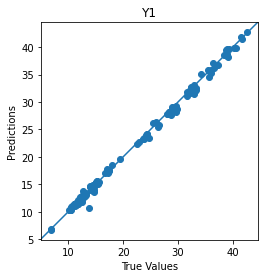

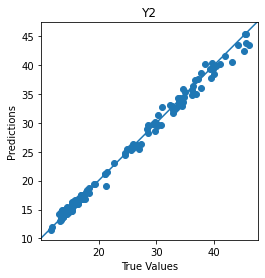

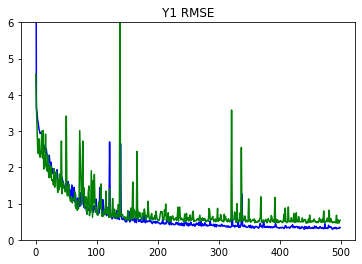

In [ ]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)